# Recurrent neural networks

We show how to implement RNNs from scratch.



In [1]:
import jax.numpy as jnp                      # JAX NumPy API for accelerated array operations
import matplotlib.pyplot as plt                # Plotting library for creating figures
import math                                   # Standard Python math functions (sqrt, sin, etc.)
from IPython import display                   # Utilities for displaying plots and rich output in notebooks

import jax                                    # Core JAX library for jit, vmap, random keys, etc.

# Lazily install and import Flax's Linen API if not already available
try:
    import flax.linen as nn                   # Flax's neural network API for defining models
except ModuleNotFoundError:
    %pip install -qq flax                     # Quietly install Flax
    import flax.linen as nn
# Utilities for replicating/collecting parameters across devices
from flax import jax_utils

# Lazily install and import Optax optimizers if missing
try:
    import optax                               # Optax: gradient processing and optimization library
except ModuleNotFoundError:
    %pip install -qq optax                    # Quietly install Optax
    import optax

import collections                            # Container datatypes like deque, namedtuple, Counter
import re                                     # Regular expressions for text processing
import random                                 # Python's random module for non-JAX randomness
import os                                     # File and directory operations
import requests                               # HTTP library for downloading data
import hashlib                                # Hashing algorithms (e.g., for file integrity checks)
import time                                   # Time utilities for measuring durations
import functools                              # Higher-order functions like partial, wraps

# Ensure reproducibility for Python's random module
random.seed(0)
# Initialize JAX PRNG key for deterministic randomness in JAX operations
rng = jax.random.PRNGKey(0)

# Create a directory to save generated figures (no error if it already exists)
os.makedirs('figures', exist_ok=True)

# Data

 As data, we use the book "The Time Machine" by H G Wells,
preprocessed using the code in [this colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/text_preproc_torch.ipynb).

In [2]:
class SeqDataLoader:
    """
    Data loader for sequential text data, yielding batches of subsequences for training language models.

    Parameters
    ----------
    batch_size : int
        Number of sequences per batch.
    num_steps : int
        Length of each sequence chunk (number of time steps).
    use_random_iter : bool
        If True, sample sequence chunks randomly; otherwise, traverse sequentially.
    max_tokens : int
        Maximum number of tokens to include from the dataset.

    Attributes
    ----------
    corpus : list of int
        Flattened token ids from the loaded text corpus.
    vocab : Vocab
        Vocabulary mapping between tokens and indices.
    data_iter_fn : callable
        Iterator function: seq_data_iter_random or seq_data_iter_sequential.
    """

    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        # Choose the iteration function based on random vs. sequential sampling
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        # Load corpus and vocabulary from the Time Machine dataset (or similar)
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        # Store batch settings
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        """
        Return an iterator over (X, Y) pairs, where:
        - X has shape (batch_size, num_steps) of input token indices
        - Y has the same shape, offset by one time step
        """
        # Call the chosen iterator function with current corpus and settings
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)


class Vocab:
    """
    Vocabulary wrapper for mapping between tokens and numerical indices.

    Parameters
    ----------
    tokens : list of str, optional
        List of tokens (e.g., characters or words) from which to build the vocabulary.
    min_freq : int, default=0
        Minimum frequency threshold; tokens appearing fewer times are excluded.
    reserved_tokens : list of str, optional
        Special tokens (e.g., '<pad>', '<bos>') that are always included.
    """

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        # Default to empty lists if none provided
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Count token frequencies in the corpus
        counter = count_corpus(tokens)
        # Sort tokens by descending frequency
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # Reserve index 0 for unknown tokens
        self.unk = 0
        # Start building unique token list with '<unk>' and any reserved tokens
        uniq_tokens = ['<unk>'] + reserved_tokens
        # Add tokens meeting the frequency threshold, skipping duplicates
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]

        # Create mappings: index to token and token to index
        self.idx_to_token = []
        self.token_to_idx = {}
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        """
        Return the size of the vocabulary (number of unique tokens).
        """
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        """
        Convert token(s) to index/indices. Returns 0 (unk) if token not found.

        Parameters
        ----------
        tokens : str or list of str
            Single token or list of tokens to convert.

        Returns
        -------
        int or list of int
            Corresponding index or list of indices.
        """
        if not isinstance(tokens, (list, tuple)):
            # Return index for single token, defaulting to unk
            return self.token_to_idx.get(tokens, self.unk)
        # Recursively process list of tokens
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        """
        Convert index/indices back to token(s).

        Parameters
        ----------
        indices : int or list of int
            Single index or list of indices to convert.

        Returns
        -------
        str or list of str
            Corresponding token or list of tokens.
        """
        if not isinstance(indices, (list, tuple)):
            # Return token for a single index
            return self.idx_to_token[indices]
        # Recursively process list of indices
        return [self.idx_to_token[i] for i in indices]

In [3]:
def tokenize(lines, token="word"):
    """Split text lines into word or character tokens."""
    if token == "word":
        return [line.split() for line in lines]
    elif token == "char":
        return [list(line) for line in lines]
    else:
        print("ERROR: unknown token type: " + token)


def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


def seq_data_iter_random(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1) :]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos : pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i : i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield jnp.array(X), jnp.array(Y)


def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = jnp.array(corpus[offset : offset + num_tokens])
    Ys = jnp.array(corpus[offset + 1 : offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i : i + num_steps]
        Y = Ys[:, i : i + num_steps]
        yield X, Y

In [4]:
def download(name, cache_dir=os.path.join("..", "data")):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f"Downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname


def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download("time_machine"), "r") as f:
        lines = f.readlines()
    return [re.sub("[^A-Za-z]+", " ", line).strip().lower() for line in lines]


def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, "char")
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab


def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [5]:
DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"
DATA_HUB["time_machine"] = (DATA_URL + "timemachine.txt", "090b5e7e70c295757f55df93cb0a180b9691891a")

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

# Model

We fit an unconditional RNN, for language modeling (ie. not vec2seq or seq2seq. Following the D2L notation, the model has the form
$$\begin{align}
H_t &= \phi(X_t W_{xh} + H_{t-1}  W_{hh} + b_h) \\
O_t &= H_t W_{hq} + b_q
\end{align}
$$
where $X_t$ is the $(n,d)$ matrix of (one-hot) inputs
(for batch size $n$ and vocabulary size $d$),
$H_t$ is the $(n,h)$ matrix of hidden states
(for $h$ hidden states),
and $O_t$ is the $(n,q)$ matrix of output logits
(for $q$ output labels, often $q=d$).



In [6]:
# Create the initial parameters
def get_params(vocab_size, num_hiddens, init_rng):
    num_inputs = num_outputs = vocab_size

    def normal(shape, rng):
        return jax.random.normal(rng, shape=shape) * 0.01

    hidden_rng, out_rng = jax.random.split(init_rng)
    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens), hidden_rng)
    W_hh = normal((num_hiddens, num_hiddens), hidden_rng)
    b_h = jnp.zeros(num_hiddens)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs), out_rng)
    b_q = jnp.zeros(num_outputs)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return params

In [7]:
# Create the initial state
# We assume this is a tuple of one element (later we will use longer tuples)
def init_rnn_state(batch_size, num_hiddens):
    return (jnp.zeros((batch_size, num_hiddens)),)

In [8]:
# Forward function.
# Input sequence is (T,B,V), where T is length of the sequence, B is batch size, V is vocab size.
# We iterate over each time step, and process the batch (for that timestep in parallel).
# Output sequence is (T*B, V), since we concatenate all the time steps.
# We also return the final state, so we can process the next subsequence.
@jax.jit
def rnn(params, state, inputs):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    (H,) = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = jnp.tanh((X @ W_xh) + (H @ W_hh) + b_h)
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return jnp.concatenate(outputs, axis=0), (H,)

In [9]:
# Make the model class
# Input X to apply is (B,T) matrix of integers (from vocab encoding).
# We transpose this to (T,B) then one-hot encode to (T,B,V), where V is vocab.
# The result is passed to the forward function.
# (We define the forward function as an argument, so we can change it later.)


class RNNModelScratch:
    """A RNN Model implemented from scratch."""

    def __init__(self, vocab_size, num_hiddens, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.get_params = init_state, get_params
        self.forward_fn = forward_fn

    def apply(self, params, state, X):
        X = jax.nn.one_hot(X.T, num_classes=self.vocab_size)
        return self.forward_fn(params, state, X)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

    def init_params(self, rng):
        return self.get_params(self.vocab_size, self.num_hiddens, rng)

In [10]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, get_params, init_rnn_state, rnn)

In [11]:
X = jnp.arange(10).reshape((2, 5))  # batch 2, sequence length is 5
params = net.init_params(rng)
state = net.begin_state(X.shape[0])
print(len(state))  # length 1
print(state[0].shape)  # (2,512)

Y, new_state = net.apply(params, state, X)
print(len(vocab))  # 28
print(Y.shape)  # (2x5, 28)

1
(2, 512)
28
(10, 28)


# Prediction (generation)

We pass in an initial prefix string, that is not generated. This is used to "warm-up" the hidden state. Specifically, we update the hidden state given the observed prefix, but don't generate anything. After that, for each of the T steps, we compute the (1,V) output tensor, pick the argmax index, and append it to the output. Finally, we convert the to indices to readable token sequence of size (1,T). (Note that this is a greedy, deterministic procedure.)

In [12]:
def predict(prefix, num_preds, net, params, vocab):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: jnp.array([outputs[-1]]).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net.apply(params, state, get_input())
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net.apply(params, state, get_input())
        y = y.reshape(-1, y.shape[-1])
        outputs.append(int(y.argmax(axis=1).item()))
    return "".join([vocab.idx_to_token[i] for i in outputs])

In [13]:
# sample 10 characters after the prefix.
# since the model is untrained, the results will be garbage.
predict("time traveller ", 10, net, params, vocab)

'time traveller tig tig ti'

# Training


To ensure the gradient doesn't blow up when doing backpropagation through many layers, we use gradient clipping, which corresponds to the update
$$
g := \min(1, \theta /||g||) g
$$
where $\theta$ is the scaling parameter, and $g$ is the gradient vector.



In [14]:
@jax.jit
def grad_clipping(grads, theta):
    """Clip the gradient."""

    def grad_update(grads):
        return jax.tree_map(lambda g: g * theta / norm, grads)

    norm = jnp.sqrt(sum(jax.tree_util.tree_leaves(jax.tree_map(lambda x: jnp.sum(x**2), grads))))
    # Update gradient if norm > theta
    # This is jax.jit compatible
    grads = jax.lax.cond(norm > theta, grad_update, lambda g: g, grads)
    return grads

The training step is fairly standard, except for the use of gradient clipping, and the issue of the hidden state.
If the data iterator uses random ordering of the sequences, we need to initialize the hidden state for each minibatch. However, if the data iterator uses sequential ordering, we only initialize the hidden state at the very beginning of the process. In the latter case, the hidden state will depend on the value at the previous minibatch.

The state vector may be a tensor or a tuple, depending on what kind of RNN we are using. In addition, the parameter updater can be an optax optimizer, or a simpler custom sgd optimizer.


In [15]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return jnp.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


@jax.jit
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    params = jax.tree_map(lambda p, g: p - lr * g / batch_size, params, grads)
    return params

In [16]:
@jax.jit
def train_step(apply_fn, loss_fn, params, state, X, Y):
    def loss(params, state, X, Y):
        y = Y.T.reshape(-1)  # (B,T) -> (T,B)
        y_hat, state = apply_fn(params, state, X)
        y_hat = y_hat.reshape(-1, y_hat.shape[-1])
        y_one_hot = jax.nn.one_hot(y, num_classes=y_hat.shape[-1])
        return loss_fn(y_hat, y_one_hot).mean(), state

    grad_fn = jax.value_and_grad(loss, has_aux=True)
    (l, state), grads = grad_fn(params, state, X, Y)
    grads = grad_clipping(grads, 1)
    return l, state, grads

In [17]:
def train_epoch(net, params, train_iter, loss, updater, use_random_iter):
    state, timer = None, Timer()
    metric = Accumulator(2)  # Sum of training loss, no. of tokens
    if isinstance(updater, optax.GradientTransformation):
        updater_state = updater.init(params)
    # Convert to jax Partial functions for jax.jit compatibility
    apply_fn = jax.tree_util.Partial(net.apply)
    loss_fn = jax.tree_util.Partial(loss)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0])
        l, state, grads = train_step(apply_fn, loss_fn, params, state, X, Y)
        if isinstance(updater, optax.GradientTransformation):
            updates, updater_state = updater.update(grads, updater_state)
            params = optax.apply_updates(params, updates)
        else:
            # batch_size=1 since the `mean` function has been invoked
            params = updater(params, grads, batch_size=1)
        metric.add(l * Y.size, Y.size)
    return params, math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

The main training function is fairly standard.
The loss function is per-symbol cross-entropy, $-\log q(x_t)$, where $q$ is the model prediction from the RNN. Since we compute the average loss across time steps within a batch, we are computing $-\frac{1}{T} \sum_{t=1}^T \log p(x_t|x_{1:t-1})$. The exponential of this is the perplexity (ppl). We plot this metric during training, since it is independent of document length. In addition, we print the MAP sequence prediction following the suffix 'time traveller', to get a sense of what the model is doing.

In [18]:
def train(net, params, train_iter, vocab, lr, num_epochs, use_random_iter=False):
    loss = optax.softmax_cross_entropy
    animator = Animator(xlabel="epoch", ylabel="perplexity", legend=["train"], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = optax.sgd(lr)
    else:
        updater = lambda params, grads, batch_size: sgd(params, grads, lr, batch_size)
    num_preds = 50
    predict_ = lambda prefix: predict(prefix, num_preds, net, params, vocab)
    # Train and predict
    for epoch in range(num_epochs):
        params, ppl, speed = train_epoch(net, params, train_iter, loss, updater, use_random_iter)
        if (epoch + 1) % 10 == 0:
            # Prediction takes time on the flax model
            # print(predict_('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = jax.default_backend()
    print(f"perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {device}")
    print(predict_("time traveller"))
    print(predict_("traveller"))
    return params

perplexity 1.0, 82998.5 tokens/sec on gpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


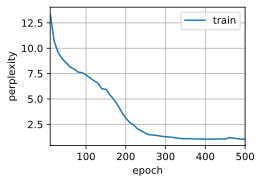

In [19]:
random.seed(0)
num_epochs, lr = 500, 1
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, get_params, init_rnn_state, rnn)
params = net.init_params(rng)
params = train(net, params, train_iter, vocab, lr, num_epochs)

In [20]:
num_preds = 100
predict_ = lambda prefix: predict(prefix, num_preds, net, params, vocab)

print(predict_("time traveller \n"))
print(predict_("the"))

time traveller <unk>other wh has a grmed and you smit react bat thing to the end of our livesthat said a very young man 
the german scholars have improved greek so muchthen there is the future said the very young man just th


In [21]:
num_preds = 500
predict_ = lambda prefix: predict(prefix, num_preds, net, params, vocab)

print(predict_("the"))

the german scholars have improved greek so muchthen there is the future said the very young man just thinkone might invest all one s money leave it to accumulate atinterest and hurry on aheadto discover a society said i erected on a strictly communisticbasisof all the wild extravagant te tam and we berale in time as we move about in the other dimensions of spacethere that uleatable har and aid aid firimedyci venely have an ansugo ac aldid you gimentyorgeis thes sothe sothuurd arectes ol shad ther h


# Creating a Flax module

We now show how to use create an RNN as a module, which is faster than our pure Python implementation.

While Flax has cells for more advanced recurrent models, it does not have a basic RNNCell. Therefore, we create an RNNCell similar to those defined in `flax.linen.recurrent` [here](https://flax.readthedocs.io/en/latest/_modules/flax/linen/recurrent.html).

In [22]:
from typing import Any, Callable, Tuple

PRNGKey = Any
Shape = Tuple[int]
Dtype = Any
Array = Any


class RNNCell(nn.recurrent.RNNCellBase):
    """RNN Cell."""

    activation_fn: Callable[..., Any] = nn.activation.tanh
    kernel_init: Callable[[PRNGKey, Shape, Dtype], Array] = nn.linear.default_kernel_init
    recurrent_kernel_init: Callable[[PRNGKey, Shape, Dtype], Array] = nn.initializers.orthogonal()
    bias_init: Callable[[PRNGKey, Shape, Dtype], Array] = nn.initializers.zeros

    @nn.compact
    def __call__(self, carry, inputs):
        """RNN Cell.

        Args:
            carry: the hidden state of the RNN cell,
                initialized using `RNNCell.initialize_carry`.
            inputs: an ndarray with the input for the current time step.
                All dimensions except the final are considered batch dimensions.

        Returns:
            A tuple with the new carry and the output.
        """
        h = carry
        hidden_features = h.shape[-1]
        # Dense layer applied to the previous state
        dense_h = functools.partial(
            nn.Dense,
            features=hidden_features,
            use_bias=False,
            kernel_init=self.recurrent_kernel_init,
            bias_init=self.bias_init,
        )
        # Dense layer applied to the input, i
        dense_i = functools.partial(
            nn.Dense, features=hidden_features, use_bias=True, kernel_init=self.kernel_init, bias_init=self.bias_init
        )
        new_h = self.activation_fn(dense_i()(inputs) + dense_h()(h))
        return new_h, new_h

    @staticmethod
    def initialize_carry(rng, batch_dims, size, init_fn=nn.initializers.zeros):
        """Initialize the RNN cell carry.
        Args:
            rng: random number generator passed to the init_fn.
            batch_dims: a tuple providing the shape of the batch dimensions.
            size: the size or number of features of the memory.
            init_fn: initializer function for the carry.
        Returns:
            An initialized carry for the given RNN cell.
        """
        mem_shape = batch_dims + (size,)
        return init_fn(rng, mem_shape)

Now, we create an RNN module to call the RNNCell for each step.

In [23]:
class RNN(nn.Module):
    @functools.partial(
        nn.transforms.scan, variable_broadcast="params", in_axes=0, out_axes=0, split_rngs={"params": False}
    )
    @nn.compact
    def __call__(self, state, x):
        return RNNCell()(state, x)

    @staticmethod
    def initialize_carry(rng, batch_dims, size):
        return RNNCell.initialize_carry(rng, batch_dims, size)

In [24]:
num_hiddens = 256
rnn_layer = RNN()

batch_size, num_steps = 32, 35
state = rnn_layer.initialize_carry(rng, (batch_size,), num_hiddens)
state.shape

(32, 256)

Now we update the state with a random one-hot array of inputs.

In [25]:
X = jax.random.normal(rng, shape=(num_steps, batch_size, len(vocab)))
params = rnn_layer.init(rng, state, X)
state_new, Y = rnn_layer.apply(params, state, X)
Y.shape, state_new.shape

((35, 32, 256), (32, 256))

Now we define our model. It consists of an RNN Layer followed by a dense layer.

In [26]:
class RNNModel(nn.Module):
    """The RNN model."""

    rnn: nn.Module
    vocab_size: int
    num_hiddens: int
    bidirectional: bool = False

    def setup(self):
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        if not self.bidirectional:
            self.num_directions = 1
        else:
            self.num_directions = 2

    @nn.compact
    def __call__(self, state, inputs):
        X = jax.nn.one_hot(inputs.T, num_classes=self.vocab_size)
        state, Y = self.rnn(state, X)
        output = nn.Dense(self.vocab_size)(Y)
        return output, state

    def begin_state(self, batch_size=1):
        # Use fixed random key since default state init fn is just `zeros`.
        return self.rnn.initialize_carry(jax.random.PRNGKey(0), (batch_size,), num_hiddens)

Test the untrained model.

In [27]:
net = RNNModel(rnn=rnn_layer, vocab_size=len(vocab), num_hiddens=num_hiddens)
params = net.init(rng, state, jnp.ones([batch_size, num_steps]))
predict("time traveller", 50, net, params, vocab)

'time travellermcudgdqmiuxmcqlntdpcrslgyuamiqigtjphfasbnwhelnllat'

Train it. The results are similar to the 'from scratch' implementation, but much faster.

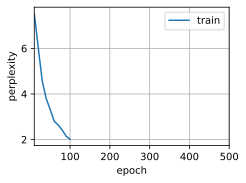

In [ ]:
num_epochs, lr = 500, 1
params = train(net, params, train_iter, vocab, lr, num_epochs)